# Parkrun twitter analysis

Jenny Woods April 2020

Code to carry out simple natural language processing (NLP) on tweets with #parkrun hashtag.

Using *tweepy* to grab tweets and *spaCy* and *NLTK* for NLP.


... Sentiment analysis to follow!

#### Import libraries

In [13]:
import pandas as pd
import pickle
import json

import matplotlib.pyplot as plt
%matplotlib inline

import tweepy

import spacy
nlp = spacy.load("en_core_web_sm")
import nltk
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')
import wordsegment
wordsegment.load()

#### Functions to read and write df to pickle

In [2]:
def write_pkl(fname, df):
    with open(fname,'wb') as pklf:
        pickle.dump((df), pklf)
        print('Saved to', fname)
        
def read_pkl(fname):
    with open(fname,'rb') as pklf:
        df = pickle.load(pklf)
    return df

#### Twitter API authentication

API authentication keys are required to grab tweets.

My twitter developer acc auth details are stored in and extracted from file *twitterAPIauth_keys*

In [22]:
with open('../twitterAPIauth_keys', 'r') as f:
    twitterAPIauth_keys = json.load(f)
    
consumer_key = twitterAPIauth_keys['consumer_key']
consumer_secret = twitterAPIauth_keys['consumer_secret']
access_token = twitterAPIauth_keys['access_token']
access_token_secret = twitterAPIauth_keys['access_token_secret']

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

#### Function to clean tweet text

In [23]:
def clean_tweet_(text):
    text = text.encode('ascii',errors='ignore').decode('UTF-8') # remove symbols, decode (remove b')
    text = text.lower().strip('\n') # make lowercase, remove newlines
    text = text.replace('&amp;', 'and') # remove &amp;
    return text

## Tweets with #parkrun hashtag

Using tweepy api.search here. See http://docs.tweepy.org/en/latest/api.html for other tweepy classes. Eg to grab home timeline, use api.home_timeline:

        for tweet in api.home_timeline() :
            print(tweet.text)


### Grab tweets and write dataframe to pickle

This grabs tweets **in the last week** - if *sincedate* is set to further in the past, be aware that for popular hashtags this will result in a large number of tweets and the dataframe may require a large amount of memory!

In [35]:
today = pd.Timestamp.today().date()
sincedate = today-pd.Timedelta(7, 'day') # move since date to 7 days ago

tweets=[]
for tweet in tweepy.Cursor(api.search,
                           q="#parkrun",
                           tweet_mode='extended',
                           lang="en",
                           since=sincedate).items():

    #print(tweet) # view full tweet to explore other attributes

    try :
        text = str(tweet.retweeted_status.full_text)
        tweet_type = 'Retweet'
    except AttributeError:
        text = str(tweet.full_text)
        tweet_type = 'Tweet'
        
    text = clean_tweet_(text)
        
    try :
        location = tweet.place.name+', '+tweet.place.country
    except:
        location = ''      
    
    tweets.append({"datetime": tweet.created_at,
                   #"id": tweet.id,
                   "location": location,
                   "text": text,
                   "tweet_type": tweet_type,
                   "user_handle": tweet.user.screen_name,
                   #"user_id": tweet.user.id,
                   "user_location": tweet.user.location,
                  })

tweets_df = pd.DataFrame(tweets)

fname = 'parkrun_tweets_'+str(sincedate)+'_to_'+str(today)+'.pkl'
write_pkl(fname, tweets_df)

Saved to parkrun_tweets_2020-04-06_to_2020-04-13.pkl


### OR, read tweets from pickle

In [38]:
fname = 'parkrun_tweets_2020-04-06_to_2020-04-13.pkl'

tweets_df = read_pkl(fname)
tweets_df.head(10)

,datetime,location,text,tweet_type,user_handle,user_location
0,2020-04-13 14:48:29,,the lockdown at least means the #parkrun #poet...,Retweet,TimGardiner3,"Manningtree, England"
1,2020-04-13 14:47:35,,the lockdown at least means the #parkrun #poet...,Tweet,parkrunpoetry,"Manningtree, England"
2,2020-04-13 14:35:45,,"back garden / back years parkrun, 5k challenge...",Tweet,tonyjamesrun,"North West, England"
3,2020-04-13 13:46:13,,@parkrunuk time to issue some 'motivational' #...,Tweet,sgallacher65,London
4,2020-04-13 13:45:56,,well get through this together\npersonalise yo...,Retweet,NickPearsonRuns,Shepperton
5,2020-04-13 13:14:56,,well get through this together\npersonalise yo...,Retweet,serimalbpickles,Wales
6,2020-04-13 13:00:10,,@daviddidau #parkrun is the next thing once co...,Tweet,AndyRobertW,
7,2020-04-13 12:48:55,,@pmsh405 @ukrunchat @parkrunuk @lincolnparkrun...,Tweet,DawnThomas2311,"Lincoln, England"
8,2020-04-13 12:45:09,,@paulteagueuk i'm making that a goal - doing m...,Tweet,wood_beez48,"UK, Europe 🇪🇺"
9,2020-04-13 12:34:25,,well get through this together\npersonalise yo...,Retweet,oliclarke68,


## Natural language processing

#### Take a look at some tweet content

In [39]:
for i in range(5,8):
    print(tweets_df['text'].iloc[i])

well get through this together
personalise your new @parkrun apricot tee with a message of your choice! what will yours be?

shop the whole collection at https://t.co/gvbnx1apv3 and we'll deliver to your door

#parkrun #loveparkrun #parkrunuk #prodirectrunning @parkrunuk https://t.co/zhmjdk6wyi
@daviddidau #parkrun is the next thing once covid 19 has done one!
@pmsh405 @ukrunchat @parkrunuk @lincolnparkrun @ulht_news @ulht_maternity thank you. day 11 of isolation so had time on my hands . miss #parkrun so much


#### Function to do the processing

Using spaCy, wordsegment and - if stemming - nltk

* **Segment hashtags and twitter handles**

* **Remove special characters, punctuation, spaces, integer tokens and web addresses**

* **Lemmatize** (group together inflected forms of a word so they can be analysed as a single item)

* **Remove stopwords** (eg is, the, a - so that more focus can be given to those words which define the meaning of the text)

* *Stem (reduce words to root form)*

In [69]:
def preprocess_(text):
    
    firstfilt=[]
    for word in text.split():
        # separate handles and hashtags into individual words (and in doing so remove #/@)
        if word[0:1] == '#' or word[0:1] == '@' :
            firstfilt.append(' '.join(wordsegment.segment(word)))
        else :
            # ignore web addresses (or at least those beginning http or www)
            if word[0:4] != 'http' and word[0:4] != 'www' :
                firstfilt.append(word)
    text = ' '.join(firstfilt)
    
    doc = nlp(text)  # Using spaCy
    tokens = []
    filtered_tokens = []
    
    for token in doc:
        if not token.is_punct | token.is_space : # ignore punctuation and spaces
            
            # LEMMATIZE
            tokens.append(token.lemma_ if token.lemma_ != '-PRON-' else token.lower_)

    for token in tokens:
        try :
            int(token) # ignore integer tokens
        except :
            lexeme = nlp.vocab[token]
            if lexeme.is_stop == False and token[0:4] : # ignore STOPWORDS
                if token[0:4] != 'http' and token[0:4] != 'www' : # ignore web addresses
                    filtered_tokens.append(token)
                    #filtered_tokens.append(stemmer.stem(token)) # Take stem of words using nltk

    return filtered_tokens

Example of processing a tweet

In [72]:
text = tweets_df['text'].iloc[0]
print('BEFORE preprocessing:\n================\n')
print(text,'\n')

filtered_tokens = preprocess_(text)
print('AFTER preprocessing:\n================\n')
print(' '.join(filtered_tokens))

BEFORE preprocessing:

the lockdown at least means the #parkrun #poetry #book 'glade runner' will be published by stour valley press run by dynamo @locomountaineer foreword by @nicolaforwood motivational words from @yiannis_83 essentially a big thank you for the work @paulsintonhewit @parkrunuk https://t.co/n3gljj8adc 

AFTER preprocessing:

lockdown mean park run poetry book glade runner publish stour valley press run dynamo loco mountaineer foreword nicola wood motivational word yiannis83 essentially big thank work paul sinton hewit park run uk


### Process all the tweets

In [76]:
tweets_df['processed text'] = tweets_df['text'].apply(lambda x: preprocess_(x))
tweets_df.head(10)

,datetime,location,text,tweet_type,user_handle,user_location,processed text
0,2020-04-13 14:48:29,,the lockdown at least means the #parkrun #poet...,Retweet,TimGardiner3,"Manningtree, England","[lockdown, mean, park, run, poetry, book, glad..."
1,2020-04-13 14:47:35,,the lockdown at least means the #parkrun #poet...,Tweet,parkrunpoetry,"Manningtree, England","[lockdown, mean, park, run, poetry, book, glad..."
2,2020-04-13 14:35:45,,"back garden / back years parkrun, 5k challenge...",Tweet,tonyjamesrun,"North West, England","[garden, year, parkrun, 5k, challenge, time, c..."
3,2020-04-13 13:46:13,,@parkrunuk time to issue some 'motivational' #...,Tweet,sgallacher65,London,"[park, run, uk, time, issue, motivational, par..."
4,2020-04-13 13:45:56,,well get through this together\npersonalise yo...,Retweet,NickPearsonRuns,Shepperton,"[personalise, new, park, run, apricot, tee, me..."
5,2020-04-13 13:14:56,,well get through this together\npersonalise yo...,Retweet,serimalbpickles,Wales,"[personalise, new, park, run, apricot, tee, me..."
6,2020-04-13 13:00:10,,@daviddidau #parkrun is the next thing once co...,Tweet,AndyRobertW,,"[david, au, park, run, thing, covid]"
7,2020-04-13 12:48:55,,@pmsh405 @ukrunchat @parkrunuk @lincolnparkrun...,Tweet,DawnThomas2311,"Lincoln, England","[pmsh405, uk, run, chat, park, run, uk, lincol..."
8,2020-04-13 12:45:09,,@paulteagueuk i'm making that a goal - doing m...,Tweet,wood_beez48,"UK, Europe 🇪🇺","[paul, teague, uk, goal, park, run]"
9,2020-04-13 12:34:25,,well get through this together\npersonalise yo...,Retweet,oliclarke68,,"[personalise, new, park, run, apricot, tee, me..."


### Take a look at simple word frequency distribution

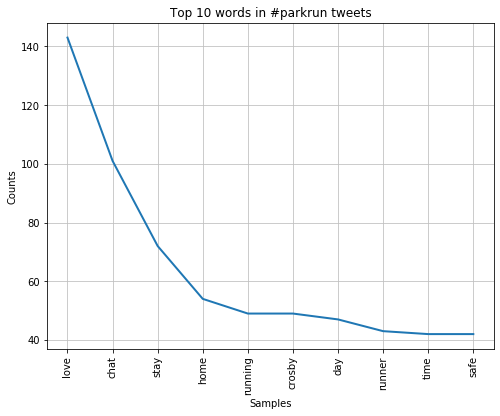

In [129]:
# concatonate words from all tweets
alltokens = [token for row in tweets_df['processed text'] for token in row]
alltokens = pd.Series(alltokens)

# remove strings 'park', 'run', 'parkrun' and 'uk' - we know these are popular!
alltokens = alltokens[(alltokens != 'park') & (alltokens != 'run') & (alltokens != 'parkrun') & (alltokens != 'uk')]

freq = nltk.FreqDist(alltokens.values)
plt.figure(figsize=(8, 6))
freq.plot(10, cumulative=False, title='Top 10 words in #parkrun tweets')
plt.show()